I use this jupyter to test whether my RNN is correct or not (Mar 20, 2023).


1. The first stage (Mar 20, 2023), I simply try to see whether RNN works or not, so 

    a. Generate X and Y without time-dependance. 
    
    b. Add noise on Y.
    
    c. It works well (Mar 20, 2023) 
    
2. The second stage, I try to generate ts with time-dependence.

    a. I generate Y first with time-dependence. 
    
    b. Then I generate X = YA
    
    c. In fact, when data are large enough, the hidden layer can help improve the performance (Mar 20, 2023)


## Import pkgs

In [1]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
from tqdm import trange

plt.style.use(FIG_ROOT/"base.mplstyle")
%matplotlib inline

In [3]:
# pkgs for pytorch (Mar 20, 2023)
import torch
import torch.nn as nn

torch.set_default_dtype(torch.float64)
torch.set_default_tensor_type(torch.DoubleTensor)

## Data, fns and parameters

In [4]:
paras = edict()
paras.d = 68 # dim of feature vector
paras.n = 10000 # length of the time series

paras.n_ouput = 7 # dim of output from RNN
paras.n_hidden = 256 # dim of hidden from RNN

paras.err_sd = 20 # error standard deviation added to x
paras.is_hidden = False# whether to include hidden or not

In [5]:
# to generate ts 
from statsmodels.tsa.arima_process import arma_generate_sample

def gen_arma_ts(ndim=7, n=paras.n):
    """Generate ARMA ndim-vec ts.
    """
    # ARMA(2, 2)
    ys = []
    for ix in range(ndim):
        arparams = np.array([.75, -.25])
        maparams = np.array([.65, .35])
        ar = np.r_[1, -arparams] # add zero-lag and negate
        ma = np.r_[1, maparams] # add zero-lag
        y = arma_generate_sample(ar, ma, n)
        ys.append(y)
    return np.array(ys)

In [6]:
# generate a toy data
torch.manual_seed(0)
Amat = torch.randn(paras.d, paras.n_ouput).T

tmp_data_y = gen_arma_ts(ndim=paras.n_ouput)
tmp_data_y = torch.tensor(tmp_data_y)
tmp_data_x1 = (tmp_data_y.T @ Amat).T # error-free
tmp_data_x = tmp_data_x1 + torch.randn_like(tmp_data_x1)*paras.err_sd # error version


tmp_data_test_y = gen_arma_ts(ndim=paras.n_ouput)
tmp_data_test_y = torch.tensor(tmp_data_test_y)
tmp_data_test_x1 = (tmp_data_test_y.T @ Amat).T # error-free
tmp_data_test_x = tmp_data_test_x1 + torch.randn_like(tmp_data_test_x1)*paras.err_sd # error version

In [7]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.mid_size = 128

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, self.mid_size)
        self.h2o = nn.Linear(hidden_size+self.mid_size, output_size)

    def forward(self, input_, hidden):
        combined = torch.cat((input_, hidden), 1)
        midput = self.i2o(combined)
        hidden = self.i2h(combined)
        midput_combined = torch.cat((hidden, midput), 1)
        output = self.h2o(midput_combined)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [8]:
# functions to generate training sample
# note that I fix the bach size = 1
def random_choice(n):
    """Randomly select the lower and upper bound of the segment
        args:
            n: len of the total time series
    """
    up_bd = torch.randint(low=100, high=n, size=(1, ))
    len_seg = torch.randint(low=10, high=50, size=(1, ))
    low_bd = up_bd - len_seg
    return low_bd.item(), up_bd.item()


def random_training_samples(data_x, data_y, bds=None):
    """Randomly select a sample from the whole segment
        args:
            data_x: total ts
            data_y: total label ts for data_x
    """
    if bds is None:
        low_bd, up_bd = random_choice(paras.n)
    else:
        low_bd, up_bd = bds
    part_data_x = torch.unsqueeze(data_x[:, low_bd:up_bd], 0)
    part_data_x = part_data_x.permute(2, 0, 1)
    
    part_data_y = torch.unsqueeze(data_y[:, low_bd:up_bd], 0)
    part_data_y = part_data_y.permute(2, 0, 1)
    return part_data_x, part_data_y

In [9]:
def train(data_x, data_y, rnn, is_hidden=paras.is_hidden):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
    seg_len = data_x.shape[0]
    for i in range(seg_len):
        if is_hidden:
            output, hidden = rnn(data_x[i], hidden)
        else:
            output, _ = rnn(data_x[i], hidden)
        loss = criterion(output, data_y[i])/seg_len + loss

        
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [10]:
def evaluate(data_x, rnn, is_hidden=paras.is_hidden):
    with torch.no_grad():
        hidden = rnn.initHidden()
    
        seg_len = data_x.shape[0]
        outputs = []
        for i in range(seg_len):
            if is_hidden:
                output, hidden = rnn(data_x[i], hidden)
            else:
                output, _ = rnn(data_x[i], hidden)
            outputs.append(output)

    return torch.cat(outputs, axis=0)

In [11]:
criterion = nn.MSELoss()
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn



## Run

### training

In [17]:
rnn1 = RNN(paras.d, paras.n_hidden, paras.n_ouput)
rnn2 = RNN(paras.d, paras.n_hidden, paras.n_ouput)

In [18]:
import time
import math

n_iters = 2000
print_every = 100
plot_every = 100



# Keep track of losses for plotting
current_loss1 = 0
current_loss2 = 0
current_test_loss1 = 0
current_test_loss2 = 0
all_losses1 = []
all_losses2 = []
test_losses1 = []
test_losses2 = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in trange(1, n_iters + 1):
    data_x, data_y = random_training_samples(tmp_data_x, tmp_data_y)
    ouput, loss1 = train(data_x, data_y, rnn1, False)
    ouput, loss2 = train(data_x, data_y, rnn2, True)
    
    # train loss 
    true_y = data_y.squeeze()
    pred_y1 = evaluate(data_x, rnn1, False)
    pred_y2 = evaluate(data_x, rnn2, True)
    loss1 = ((pred_y1-true_y)**2).mean(axis=1).sqrt().mean().item()
    loss2 = ((pred_y2-true_y)**2).mean(axis=1).sqrt().mean().item()
    current_loss1 += loss1
    current_loss2 += loss2

    # test
    test_x, test_y = random_training_samples(tmp_data_test_x, tmp_data_test_y)
    true_y = test_y.squeeze()
    pred_y1 = evaluate(test_x, rnn1, False)
    pred_y2 = evaluate(test_x, rnn2, True)
    test_loss1 = ((pred_y1-true_y)**2).mean(axis=1).sqrt().mean().item()
    test_loss2 = ((pred_y2-true_y)**2).mean(axis=1).sqrt().mean().item()
    current_test_loss1 += test_loss1
    current_test_loss2 += test_loss2
    
    # Print iter number, loss, name and guess
    if iter % print_every == 1e10:
        print('%d %d%% (%s) %.4f' % (iter, iter / n_iters * 100, timeSince(start), loss1))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses1.append(current_loss1 / plot_every)
        all_losses2.append(current_loss2 / plot_every)
        test_losses1.append(current_test_loss1 / plot_every)
        test_losses2.append(current_test_loss2 / plot_every)
        current_loss1 = 0
        current_loss2 = 0
        current_test_loss1 = 0
        current_test_loss2 = 0

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:07<00:00, 29.57it/s]


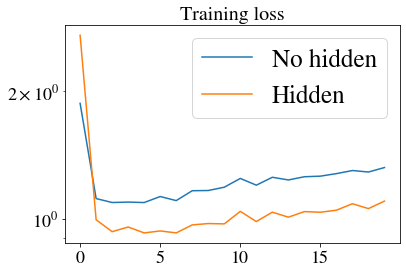

In [19]:
plt.plot(all_losses1, label="No hidden")
plt.plot(all_losses2, label="Hidden")
plt.title("Training loss", fontsize=20)
plt.yscale("log")
plt.legend()

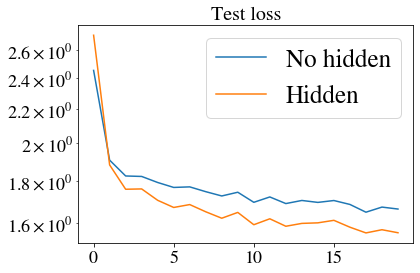

In [20]:
plt.plot(test_losses1, label="No hidden")
plt.plot(test_losses2, label="Hidden")
plt.title("Test loss", fontsize=20)
plt.yscale("log")
plt.legend()

### Evaluate

In [32]:
test_x, test_y = random_training_samples(tmp_data_x, tmp_data_y, bds=[1, 10000])
#test_x, test_y = random_training_samples(tmp_data_test_x, tmp_data_test_y, bds=[1, 10000])

In [33]:
pred_y1 = evaluate(test_x, rnn1, False)
pred_y2 = evaluate(test_x, rnn2, True)
true_y = test_y.squeeze()
print(torch.norm(pred_y1-true_y))
print(torch.norm(pred_y2-true_y))

tensor(446.2874)
tensor(409.3959)


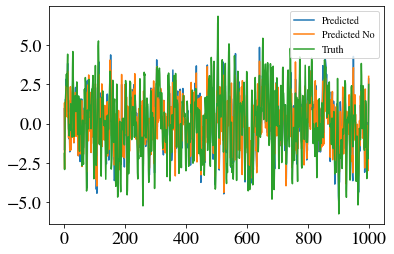

In [24]:
idx = 0
plt.plot(pred_y2[:, idx], label="Predicted")
plt.plot(pred_y1[:, idx], label="Predicted No")
plt.plot(true_y[:, idx], label="Truth")
plt.legend(fontsize=10)